<a href="https://colab.research.google.com/github/RanaZay/Speech-Recognition-0-9/blob/main/DigitSpeak_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="border: 2px solid #4CAF50; padding: 15px; background-color: #f9f9f9; border-radius: 10px;">
    <h1 style="color: #4CAF50;">Digits Speech Recognition on Google Speech Commands</h1>
    <p>This notebook demonstrates how to predict spoken digits from audio files using a  neural network model. The process involves the following steps:</p>
    <ul>
        <li>Preprocessing the audio files from dataset to extract MFCC features.</li>
        <li>Loading a trained model.</li>
        <li>Using the model to predict the digit for a given audio file.</li>
    </ul>
    <p>Let's get started!</p>
</div>


<div style="border: 2px solid #2196F3; padding: 15px; background-color: #e3f2fd; border-radius: 10px;">
    <h2 style="color: #2196F3;">Imports and Setup</h2>
    <p>We begin by importing the necessary libraries and setting up the environment for audio processing and model prediction.</p>
</div>


In [ ]:
import pathlib
import seaborn
from IPython import display
from sklearn.preprocessing import LabelEncoder


import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
import librosa
import librosa.display


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d neehakurelli/google-speech-commands --path /content/drive/MyDrive/SpeechCommands

Dataset URL: https://www.kaggle.com/datasets/neehakurelli/google-speech-commands
License(s): unknown
100% 1.38G/1.38G [00:24<00:00, 50.4MB/s]
100% 1.38G/1.38G [00:24<00:00, 60.0MB/s]


In [ ]:
import os
import zipfile

# Define the path to the zip file and the extraction directory
zip_path = '/content/drive/MyDrive/SpeechCommands/google-speech-commands.zip'
extract_dir = '/content/drive/MyDrive/SpeechCommands'

# Check if the zip file exists
if not os.path.exists(zip_path):
    print(f"Zip file not found at {zip_path}")
else:
    try:
        # Attempt to open and extract the zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Extraction completed successfully to {extract_dir}")
    except zipfile.BadZipFile:
        print(f"The file at {zip_path} is not a zip file or it is corrupted.")
    except Exception as e:
        print(f"An error occurred: {e}")


Extraction completed successfully to /content/drive/MyDrive/SpeechCommands


In [ ]:
extract_dir = '/content/drive/MyDrive/SpeechCommands'
# List the extracted files and folders
extracted_files = os.listdir(extract_dir)
print("Extracted files and folders:")
print(len(extracted_files))

Extracted files and folders:
36


<div style="border: 2px solid #FF9800; padding: 15px; background-color: #fff3e0; border-radius: 10px;">
    <h2 style="color: #FF9800;">Data Preprocessing</h2>
    <p>This section covers the preprocessing of audio files to extract MFCC features. These features are essential for the model to make accurate predictions.</p>
</div>


<div style="border: 2px solid #2196F3; padding: 15px; background-color: #e3f2fd; border-radius: 10px;">
    <h2 style="color: #2196F3;">Mel-Frequency Cepstral Coefficients (MFCC)</h2>
    <p>MFCC is a representation of the short-term power spectrum of a sound. It's widely used in speech and audio processing because it effectively captures the timbral aspects of the sound. The process involves:</p>
    <ol>
        <li>Taking the Fourier transform of a windowed signal.</li>
        <li>Mapping the powers of the spectrum to the mel scale.</li>
        <li>Taking the logarithm of the powers at each mel frequency.</li>
        <li>Taking the discrete cosine transform of the resulting coefficients.</li>
    </ol>
</div>


<div style="border: 2px solid #FF9800; padding: 15px; background-color: #fff3e0; border-radius: 10px;">
    <h2 style="color: #FF9800;">Loading and Preprocessing the Dataset</h2>
    <p>In this section, we load and preprocess the dataset. The dataset contains audio recordings of spoken digits ("zero" to "nine"). The preprocessing steps include:</p>
    <ol>
        <li>Loading each audio file.</li>
        <li>Extracting MFCC features from the audio.</li>
        <li>Ensuring consistent shape of the MFCC features.</li>
    </ol>
</div>


In [ ]:
DATASET_PATH = '/content/drive/My Drive/SpeechCommands'
DIGITS = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

def load_data(path, digits):
    x_data, y_data = [], []
    for i, digit in enumerate(digits):
        digit_path = os.path.join(path, digit)
        for filename in os.listdir(digit_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(digit_path, filename)
                y, sr = librosa.load(file_path, sr=16000)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                if mfcc.shape[1] == 32:  # Ensure consistent shape
                    x_data.append(mfcc)
                    y_data.append(i)
    return np.array(x_data), np.array(y_data)

x_data, y_data = load_data(DATASET_PATH, DIGITS)
x_data = x_data[..., np.newaxis]  # Add channel dimension
y_data = to_categorical(y_data, num_classes=len(DIGITS))

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)


<div style="border: 2px solid #4CAF50; padding: 15px; background-color: #f9f9f9; border-radius: 10px;">
    <h2 style="color: #4CAF50;">Model Architecture</h2>
    <p>The model used for digit recognition is a Convolutional Neural Network (CNN). Here’s a detailed breakdown of each layer:</p>
    <ul>
        <li><strong>Conv2D (32, (3, 3), activation='relu', input_shape=(40, 32, 1)):</strong> The first convolutional layer with 32 filters, a kernel size of (3, 3), ReLU activation, and an input shape matching the MFCC feature dimensions.</li>
        <li><strong>MaxPooling2D ((2, 2)):</strong> A max pooling layer with a pool size of (2, 2) to reduce the spatial dimensions.</li>
        <li><strong>Dropout (0.25):</strong> A dropout layer with a dropout rate of 0.25 to prevent overfitting.</li>
        <li><strong>Conv2D (64, (3, 3), activation='relu'):</strong> The second convolutional layer with 64 filters and a kernel size of (3, 3), again with ReLU activation.</li>
        <li><strong>MaxPooling2D ((2, 2)):</strong> Another max pooling layer with a pool size of (2, 2).</li>
        <li><strong>Dropout (0.25):</strong> Another dropout layer with a dropout rate of 0.25 to further prevent overfitting.</li>
        <li><strong>Flatten ():</strong> A flatten layer to convert the 2D matrix into a 1D vector for the fully connected layers.</li>
        <li><strong>Dense (128, activation='relu'):</strong> A dense (fully connected) layer with 128 units and ReLU activation.</li>
        <li><strong>Dropout (0.5):</strong> A dropout layer with a higher dropout rate of 0.5 for more aggressive regularization.</li>
        <li><strong>Dense (len(DIGITS), activation='softmax'):</strong> The output layer with a number of units equal to the number of digit classes and softmax activation to output class probabilities.</li>
    </ul>
    <p>The model is compiled with the Adam optimizer, categorical crossentropy loss function, and accuracy as the evaluation metric.</p>
</div>


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(40, 32, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(DIGITS), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 15, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 19, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 8, 6, 64)          0

In [ ]:
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/20
540/540 [==============================] - 32s 57ms/step - loss: 2.5464 - accuracy: 0.1029 - val_loss: 2.3032 - val_accuracy: 0.0888
Epoch 2/20
540/540 [==============================] - 30s 56ms/step - loss: 2.3029 - accuracy: 0.1043 - val_loss: 2.3035 - val_accuracy: 0.0895
Epoch 3/20
540/540 [==============================] - 29s 54ms/step - loss: 2.2943 - accuracy: 0.1169 - val_loss: 2.2710 - val_accuracy: 0.1194
Epoch 4/20
540/540 [==============================] - 29s 53ms/step - loss: 2.1783 - accuracy: 0.1846 - val_loss: 1.9355 - val_accuracy: 0.3123
Epoch 5/20
540/540 [==============================] - 31s 58ms/step - loss: 1.5876 - accuracy: 0.4349 - val_loss: 0.8964 - val_accuracy: 0.7090
Epoch 6/20
540/540 [==============================] - 33s 62ms/step - loss: 1.0386 - accuracy: 0.6430 - val_loss: 0.5257 - val_accuracy: 0.8535
Epoch 7/20
540/540 [==============================] - 30s 55ms/step - loss: 0.7993 - accuracy: 0.7375 - val_loss: 0.4084 - val_accuracy:

135/135 [==============================] - 2s 13ms/step - loss: 0.2213 - accuracy: 0.9362
Test accuracy: 93.62%


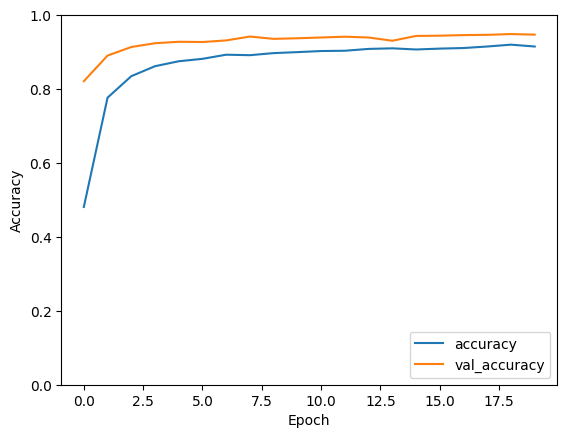

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy*100:.2f}%")

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()



In [ ]:
model.save('/content/drive/My Drive/digit_speech_recognition_TRAILmodel.h5')

In [ ]:
!pip install wandb


<div style="border: 2px solid #4CAF50; padding: 15px; background-color: #f9f9f9; border-radius: 10px;">
    <h2 style="color: #4CAF50;">Using Weights & Biases (wandb) for Experiment Tracking</h2>
    <p>Weights & Biases (wandb) is a tool for tracking and visualizing machine learning experiments. It provides an easy way to log various metrics, visualize model performance, and compare different runs. Here’s a detailed explanation of how wandb is used in this notebook:</p>
    <ul>
        <li><strong>Tracking Metrics:</strong> wandb allows you to track important metrics like training and validation accuracy, loss, and more in real-time. This helps you monitor the progress of your model training and detect any issues early on.</li>
        <li><strong>Logging Hyperparameters:</strong> You can log hyperparameters used in your experiments, such as learning rate, batch size, and number of epochs. This makes it easy to keep track of different configurations and their effects on model performance.</li>
        <li><strong>Visualizing Performance:</strong> wandb provides interactive plots and charts that help you visualize the performance of your model over time. This includes plots for accuracy, loss, and other custom metrics.</li>
        <li><strong>Comparing Runs:</strong> With wandb, you can compare different training runs side-by-side. This is particularly useful for hyperparameter tuning and understanding the impact of different changes to your model or training process.</li>
        <li><strong>Collaboration:</strong> wandb facilitates collaboration by allowing you to share your experiments and results with your team. You can easily access and review the results from different runs, making it easier to work together on improving the model.</li>
    </ul>
    <p>In this notebook, we use <code>wandb.keras.WandbCallback()</code> as a callback in the <code>model2.fit()</code> function. This callback integrates wandb with Keras, automatically logging metrics and parameters for each epoch during the training process.</p>
</div>


In [ ]:
import wandb

wandb.init(project='digit-speech-recognition')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<div style="border: 2px solid #4CAF50; padding: 15px; background-color: #f9f9f9; border-radius: 10px;">
    <h2 style="color: #4CAF50;">Changes in Model Architecture</h2>
    <p>Compared to the previous model, <code>model2</code> incorporates several significant changes to potentially improve performance:</p>
    <ul>
        <li><strong>Increased Filters:</strong> The number of filters in each convolutional layer has been increased:
            <ul>
                <li>The first <code>Conv2D</code> layer now has 64 filters instead of 32.</li>
                <li>The second <code>Conv2D</code> layer now has 128 filters instead of 64.</li>
                <li>A new third <code>Conv2D</code> layer has been added with 256 filters.</li>
            </ul>
        </li>
        <li><strong>Additional Convolutional Layer:</strong> An additional convolutional layer with 256 filters has been added to increase the model’s capacity to capture more complex features from the input data.</li>
        <li><strong>Increased Units in Dense Layer:</strong> The number of units in the fully connected <code>Dense</code> layer has been increased from 128 to 512, allowing the model to learn more complex representations before the final classification layer.</li>
    </ul>
    <p>These changes are intended to enhance the model's ability to learn from the data by providing more parameters and depth, which can be beneficial for capturing intricate patterns in the audio features.</p>
</div>


In [ ]:
model2 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(40, 32, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(DIGITS), activation='softmax')
])

In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 15, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 19, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 8, 6, 64)          0

In [ ]:
history = model2.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[wandb.keras.WandbCallback()]
)

Epoch 1/20
539/540 [============================>.] - ETA: 0s - loss: 1.5699 - accuracy: 0.4809

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240519_100205-qbn7fd1w/files/model-best)... Done. 0.1s


540/540 [==============================] - 117s 214ms/step - loss: 1.5699 - accuracy: 0.4810 - val_loss: 0.5848 - val_accuracy: 0.8212
Epoch 2/20
539/540 [============================>.] - ETA: 0s - loss: 0.6819 - accuracy: 0.7767

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240519_100205-qbn7fd1w/files/model-best)... Done. 0.1s


540/540 [==============================] - 102s 188ms/step - loss: 0.6819 - accuracy: 0.7767 - val_loss: 0.3380 - val_accuracy: 0.8906
Epoch 3/20
539/540 [============================>.] - ETA: 0s - loss: 0.5152 - accuracy: 0.8348

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240519_100205-qbn7fd1w/files/model-best)... Done. 0.1s


540/540 [==============================] - 98s 182ms/step - loss: 0.5151 - accuracy: 0.8348 - val_loss: 0.2700 - val_accuracy: 0.9137
Epoch 4/20
539/540 [============================>.] - ETA: 0s - loss: 0.4425 - accuracy: 0.8618

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240519_100205-qbn7fd1w/files/model-best)... Done. 0.1s


540/540 [==============================] - 100s 185ms/step - loss: 0.4425 - accuracy: 0.8618 - val_loss: 0.2448 - val_accuracy: 0.9240
Epoch 5/20
539/540 [============================>.] - ETA: 0s - loss: 0.4018 - accuracy: 0.8752

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240519_100205-qbn7fd1w/files/model-best)... Done. 0.1s


540/540 [==============================] - 96s 178ms/step - loss: 0.4018 - accuracy: 0.8752 - val_loss: 0.2400 - val_accuracy: 0.9279
Epoch 6/20
540/540 [==============================] - 94s 174ms/step - loss: 0.3765 - accuracy: 0.8817 - val_loss: 0.2415 - val_accuracy: 0.9272
Epoch 7/20
539/540 [============================>.] - ETA: 0s - loss: 0.3378 - accuracy: 0.8930

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240519_100205-qbn7fd1w/files/model-best)... Done. 0.1s


540/540 [==============================] - 95s 176ms/step - loss: 0.3380 - accuracy: 0.8929 - val_loss: 0.2224 - val_accuracy: 0.9316
Epoch 8/20
539/540 [============================>.] - ETA: 0s - loss: 0.3462 - accuracy: 0.8916

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240519_100205-qbn7fd1w/files/model-best)... Done. 0.1s


540/540 [==============================] - 95s 176ms/step - loss: 0.3462 - accuracy: 0.8916 - val_loss: 0.1895 - val_accuracy: 0.9420
Epoch 9/20
540/540 [==============================] - 95s 175ms/step - loss: 0.3438 - accuracy: 0.8972 - val_loss: 0.2137 - val_accuracy: 0.9358
Epoch 10/20
540/540 [==============================] - 92s 171ms/step - loss: 0.3301 - accuracy: 0.8999 - val_loss: 0.2142 - val_accuracy: 0.9374
Epoch 11/20
540/540 [==============================] - 101s 187ms/step - loss: 0.3160 - accuracy: 0.9028 - val_loss: 0.1973 - val_accuracy: 0.9395
Epoch 12/20
540/540 [==============================] - 99s 183ms/step - loss: 0.3226 - accuracy: 0.9036 - val_loss: 0.1983 - val_accuracy: 0.9416
Epoch 13/20
540/540 [==============================] - 94s 174ms/step - loss: 0.3096 - accuracy: 0.9086 - val_loss: 0.1985 - val_accuracy: 0.9395
Epoch 14/20
540/540 [==============================] - 95s 177ms/step - loss: 0.3083 - accuracy: 0.9102 - val_loss: 0.2212 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240519_100205-qbn7fd1w/files/model-best)... Done. 0.1s


540/540 [==============================] - 95s 176ms/step - loss: 0.3021 - accuracy: 0.9110 - val_loss: 0.1821 - val_accuracy: 0.9460
Epoch 18/20
539/540 [============================>.] - ETA: 0s - loss: 0.2862 - accuracy: 0.9151

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240519_100205-qbn7fd1w/files/model-best)... Done. 0.1s


540/540 [==============================] - 95s 176ms/step - loss: 0.2862 - accuracy: 0.9151 - val_loss: 0.1745 - val_accuracy: 0.9467
Epoch 19/20
539/540 [============================>.] - ETA: 0s - loss: 0.2710 - accuracy: 0.9200

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240519_100205-qbn7fd1w/files/model-best)... Done. 0.1s


540/540 [==============================] - 99s 184ms/step - loss: 0.2710 - accuracy: 0.9201 - val_loss: 0.1697 - val_accuracy: 0.9488
Epoch 20/20
540/540 [==============================] - 99s 182ms/step - loss: 0.2938 - accuracy: 0.9151 - val_loss: 0.2013 - val_accuracy: 0.9471


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy*100:.2f}%")

135/135 [==============================] - 2s 12ms/step - loss: 0.2213 - accuracy: 0.9362
Test accuracy: 93.62%


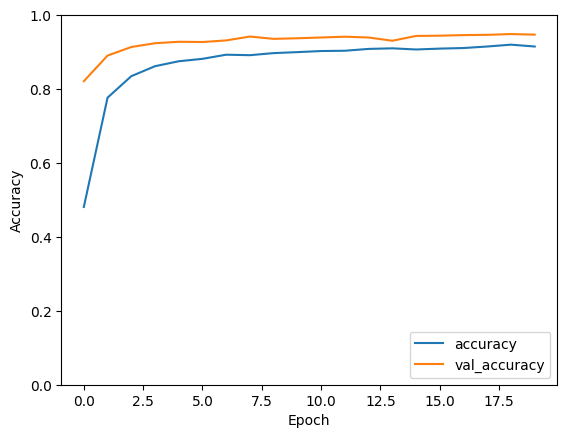

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/SavedSpeechModel/digit_speech_recognition_Finalmodel.h5')

<div style="border: 2px solid #4CAF50; padding: 15px; background-color: #f9f9f9; border-radius: 10px;">
    <h3 style="color: #4CAF50;">Audio Preprocessing and Digit Prediction</h3>
    <p>This section loads the previous pre-trained digit recognition model and defines functions to preprocess audio files and predict the corresponding digit:</p>
    <ul>
        <li><strong>Preprocess Audio:</strong> Loads an audio file, extracts MFCC features, resizes them to a consistent shape, and prepares them for model input.</li>
        <li><strong>Predict Digit:</strong> Uses the preprocessed audio to predict the digit with the trained model.</li>
    </ul>
</div>


In [ ]:
import numpy as np
import tensorflow as tf
import librosa
import librosa.display

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Lab6_number0 to 9 using CNN_7756_Deep/digit_speech_recognition_Finalmodel.h5')

# Function to preprocess audio
def preprocess_audio(audio_path, sample_rate=16000, expected_shape=(40, 32, 1)):
    y, sr = librosa.load(audio_path, sr=sample_rate)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

    # Check the current shape
    print(f"Original MFCC shape: {mfcc.shape}")

    # Resize the MFCC to the expected shape
    if mfcc.shape[1] < expected_shape[1]:
        pad_width = expected_shape[1] - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :expected_shape[1]]

    # Check the new shape
    print(f"Resized MFCC shape: {mfcc.shape}")

    mfcc = mfcc[np.newaxis, ..., np.newaxis]  # Add batch and channel dimension
    return mfcc

# Function to predict digit
def predict_digit(audio_path):
    preprocessed_audio = preprocess_audio(audio_path)
    prediction = model.predict(preprocessed_audio)
    predicted_digit = np.argmax(prediction)
    return predicted_digit


<div style="border: 2px solid #3F51B5; padding: 15px; background-color: #e8eaf6; border-radius: 10px;">
    <h2 style="color: #3F51B5;">Predictions</h2>
    <p>Finally, we predict the digits for a few test audio files and print the results.</p>
</div>


In [ ]:

# Predict the digit for the uploaded audio file
audio_file = 'test_audio9.wav'  # Path to the uploaded audio file
predicted_digit = predict_digit(audio_file)
print("Predicted Digit:", predicted_digit)

Original MFCC shape: (40, 75)
Resized MFCC shape: (40, 32)
1/1 [==============================] - 0s 99ms/step
Predicted Digit: 9


In [ ]:
# Predict the digit for the uploaded audio file
audio_file = 'test_audio1.wav'  # Path to the uploaded audio file
predicted_digit = predict_digit(audio_file)
print("Predicted Digit:", predicted_digit)

Original MFCC shape: (40, 57)
Resized MFCC shape: (40, 32)
1/1 [==============================] - 0s 71ms/step
Predicted Digit: 1


In [ ]:
# Predict the digit for the uploaded audio file
audio_file = 'test_audio7.wav'  # Path to the uploaded audio file
predicted_digit = predict_digit(audio_file)
print("Predicted Digit:", predicted_digit)

Original MFCC shape: (40, 59)
Resized MFCC shape: (40, 32)
1/1 [==============================] - 0s 150ms/step
Predicted Digit: 7
